In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 10             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 8         # length of box (L0)
H = 5         # height of box (L0)
w = .2        # width of waveguides (L0)
d = H/2.44    # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 190 grids in x and 140 grids in y
The simulation has 20 grids per free space wavelength


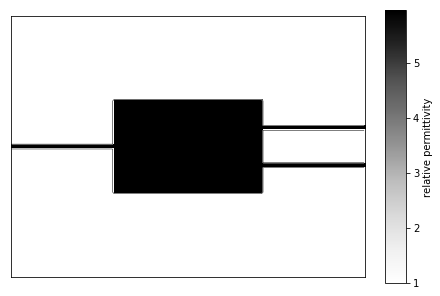

In [5]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [6]:
# check to make sure the number of points in each waveguide is the same
eps = simulation.eps_r
pts_in = np.sum(eps[NPML[0]+3,:] > 1)
pts_top = np.sum(eps[-NPML[0]-3,:ny] > 1)
pts_bot = np.sum(eps[-NPML[0]-3,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))
assert pts_in == pts_top == pts_bot, "number of grid points in each waveguide is not consistent"

waveguide has 2 points in in port
waveguide has 2 points in top port
waveguide has 2 points in bottom port


In [7]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

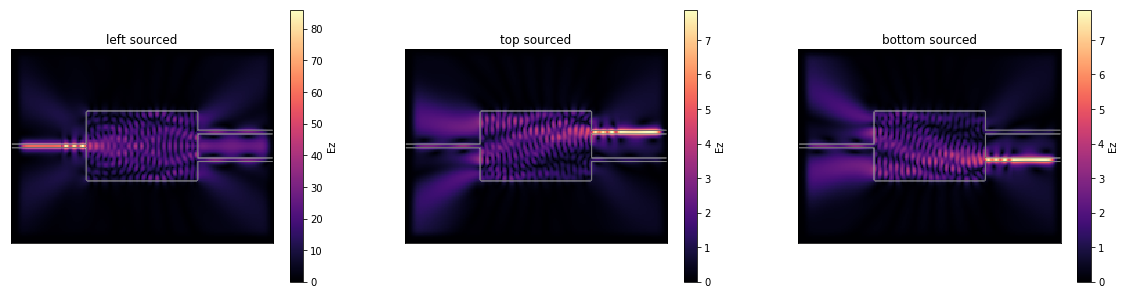

In [8]:
# set source and solve for electromagnetic fields
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

_ = simulation.solve_fields()
_ = top.solve_fields()
_ = bot.solve_fields()

simulation.plt_abs(outline=True, cbar=True, ax=ax1)
top.plt_abs(outline=True, cbar=True, ax=ax2)
bot.plt_abs(outline=True, cbar=True, ax=ax3)
ax1.set_title('left sourced')
ax2.set_title('top sourced')
ax3.set_title('bottom sourced')
plt.show()

In [9]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(H/2/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 5957.483252235515 in units of E^2 J_out


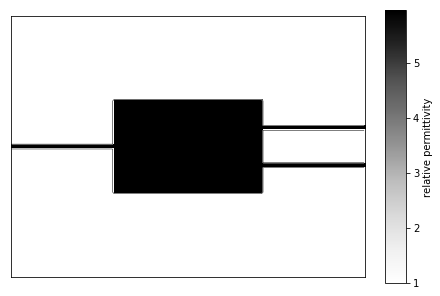

In [10]:
# set the design region to whatever you want in {'clean','halfway','random'} if None, then uses current eps of simulation
initialize = 'clean'
if initialize == 'halfway':
    eps_halfway = simulation.eps_r
    eps_halfway[design_region == 1] = eps_m/2 + 1/2
    simulation.eps_r = eps_halfway
elif initialize == 'random':
    eps_random = (eps_m-1)*np.random.random(simulation.eps_r.shape)+1
    eps_random[design_region == 0] = simulation.eps_r[design_region == 0]
    simulation.eps_r = eps_random
elif initialize == 'clean':
    eps_clean, _ = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
    simulation.eps_r = eps_clean
    
simulation.plt_eps()
plt.show()

In [11]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [22]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
    """
    BOOST = 1e7
    Binary_Penalty = 1e3
    p = 2
    linear_top =     1*npa.sum(npa.square(npa.abs(e))*J_top)
    linear_bot =    -1*npa.sum(npa.square(npa.abs(e))*J_bot)
    nonlinear_top = -1*npa.sum(npa.square(npa.abs(e_nl))*J_top)
    nonlinear_bot =  1*npa.sum(npa.square(npa.abs(e_nl))*J_bot)
    objfn = (linear_top + nonlinear_top + nonlinear_bot + linear_bot)/2
    objfn_binary = objfn - Binary_Penalty*npa.sum(npa.power(eps*design_region - npa.ones(eps.shape), p)*npa.power(eps*design_region - eps_m*npa.ones(eps.shape), p)) / Nx / Ny
    return objfn / SCALE * BOOST

In [23]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=10, eps_max=5, field_start='linear', nl_solver='newton', max_ind_shift=max_ind_shift)

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [3716.3380663240914, -2378.0924190320693, -838.226009104932, -9163.361924419129]
numerical gradient = [3716.314861085266, -2378.1279451213777, -838.2843376602978, -9163.426471641287]


In [31]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region, method='lbfgs')
# new_eps = optimization.run(simulation, design_region, method='gd', step_size=1e3)
# new_eps = optimization.run(simulation, design_region, method='adam', step_size=1e-2, beta1=0.9, beta2=0.999)

 ObjectiveFn: 1.23e+06 Iteration:  2/10 ETA:   0:05:34                         

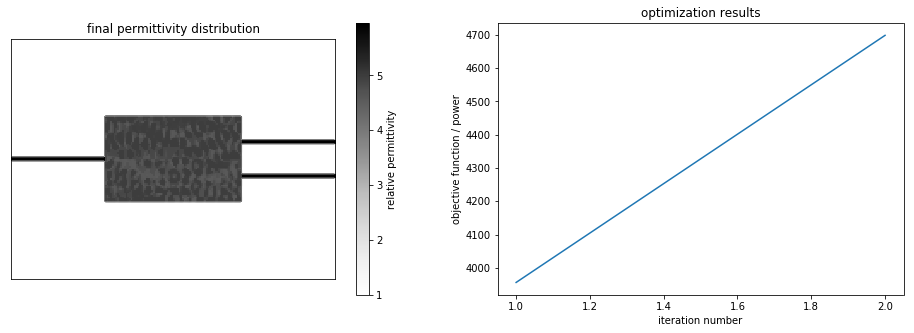

In [30]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, norm='power')
ax2.set_yscale('linear')
plt.show()

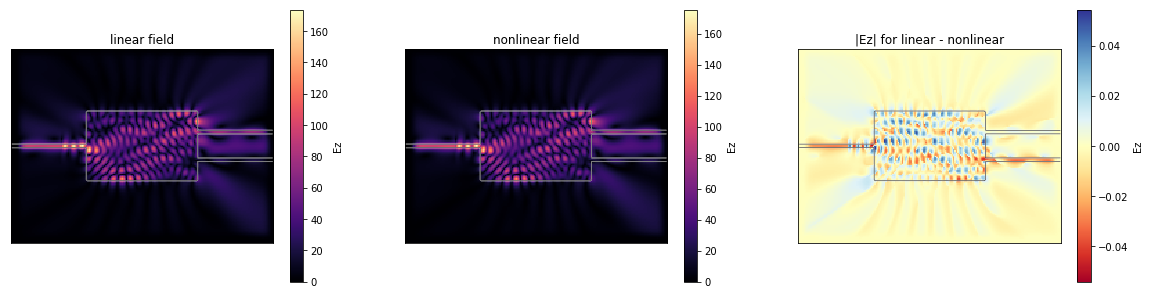

In [26]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

[autoreload of optimization failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../optimization.py", line 408
    def J_prime(*args, **kwargs):
    ^


maximum refractive index shift of 0.00569185656261606


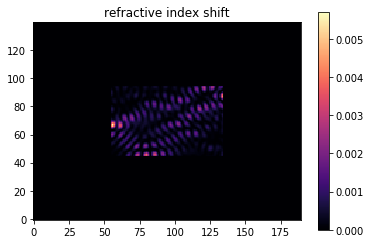

In [27]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [28]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


[autoreload of optimization failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../optimization.py", line 408
    def J_prime(*args, **kwargs):
    ^


linear transmission              = 2.5874
nonlinear transmission           = 2.5997

relative power difference        = 0.48 %
relative transmission difference = 0.48 %


100% (30 of 30) |########################| Elapsed Time: 0:01:31 ETA:  00:00:00

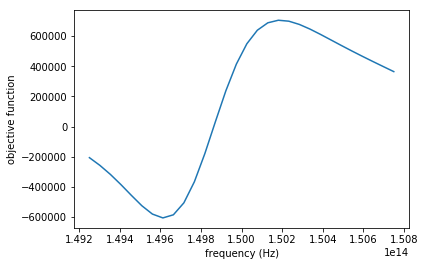

computed FWHM of 827586206896.5:


In [29]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=30, df=1/100)
optimization.simulation.omega = omega
plt.plot(freqs, objs)
plt.xlabel('frequency (Hz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {}:'.format(FWHM))